# **Problem 1A** 
Develop a multi-layer perceptron with three hidden layers (you pick the dimensions of the hidden layers) for the CIFAR-10 dataset Train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. Report and plot your training and validation results. Report precision, recall, F1 score, and confusion matrix..

In [7]:
# Main Libraries
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np

# Utility Libraries (QoL functions)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Visualization and Evaluation Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

training_dataset = datasets.CIFAR10(root='./data', train=True, transform=normalize)
validation_dataset = datasets.CIFAR10(root='./data', train=False, transform=normalize)

training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

class ImageNet(nn.Module):
    def __init__(self):
        super(ImageNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)  # 32 by 32 Image flattened as input
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)       # 10 Output Classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the network
model = ImageNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

epochs = 20

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)
    
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
        validation_loss = running_loss / len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)

        pbar.set_postfix({'Training Loss ': training_loss, 'Validation Loss ': validation_loss})

Files already downloaded and verified


Epoch 20/20: 100%|██████████| 1563/1563 [00:16<00:00, 94.24 batch/s, Training Loss =1.39, Validation Loss =0.0449] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 6.63
Estimated Total Size (MB): 6.68
----------------------------------------------------------------
Final Training Loss: 1.392372090848531

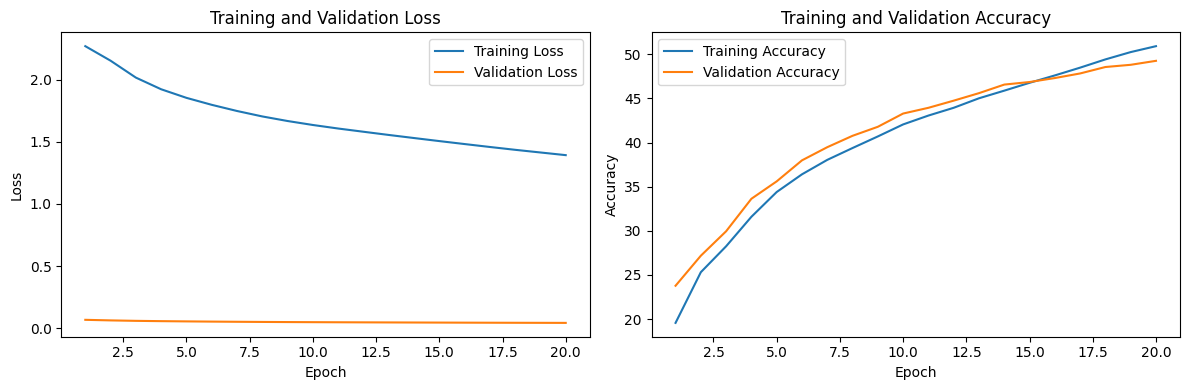

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      1000
           1       0.61      0.60      0.61      1000
           2       0.39      0.33      0.36      1000
           3       0.35      0.30      0.32      1000
           4       0.43      0.35      0.39      1000
           5       0.39      0.41      0.40      1000
           6       0.47      0.60      0.53      1000
           7       0.55      0.56      0.56      1000
           8       0.56      0.68      0.62      1000
           9       0.54      0.54      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



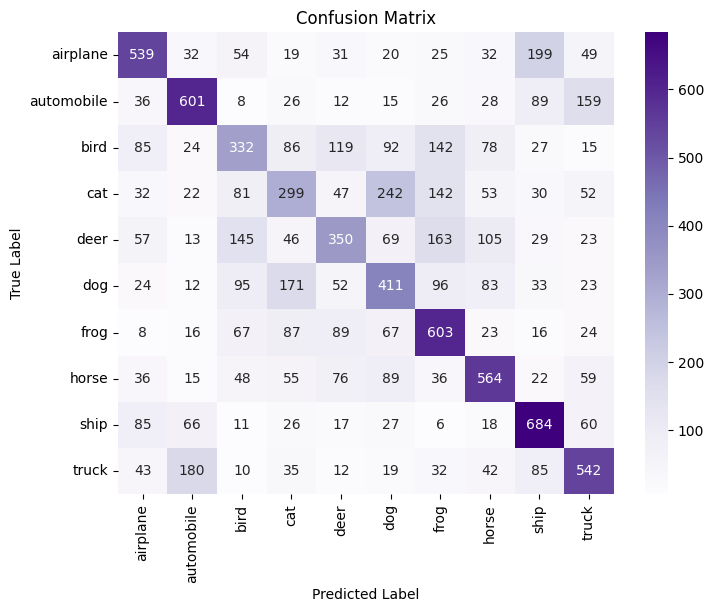

In [13]:
## Another way to calculate model parameters
# total_params = sum(p.numel() for p in net.parameters())
# print(f'Total number of parameters in the model: {total_params}')

summary(model, (3, 32, 32))  # Input images are of shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, epochs + 1)

# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Problem 1B** 
Explore the complexity of the network by increasing its width and depth. How do the training and validation results change? Compare them against the baseline. Do you see any overfitting? 

In [16]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

training_dataset = datasets.CIFAR10(root='./data', train=True, transform=normalize)
validation_dataset = datasets.CIFAR10(root='./data', train=False, transform=normalize)

training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

class ImageNet(nn.Module):
    def __init__(self):
        super(ImageNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)  # 32 by 32 Image flattened as input
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)       # 10 Output Classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize the network
model = ImageNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
epochs = 20

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)
    
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
        validation_loss = running_loss / len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)

        pbar.set_postfix({'Training Loss ': training_loss, 'Validation Loss ': validation_loss})

Files already downloaded and verified


Epoch 20/20: 100%|██████████| 1563/1563 [00:16<00:00, 94.03 batch/s, Training Loss =1.76, Validation Loss =0.0543] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
Total params: 1,748,266
Trainable params: 1,748,266
Non-trainable params: 0
---------------------------

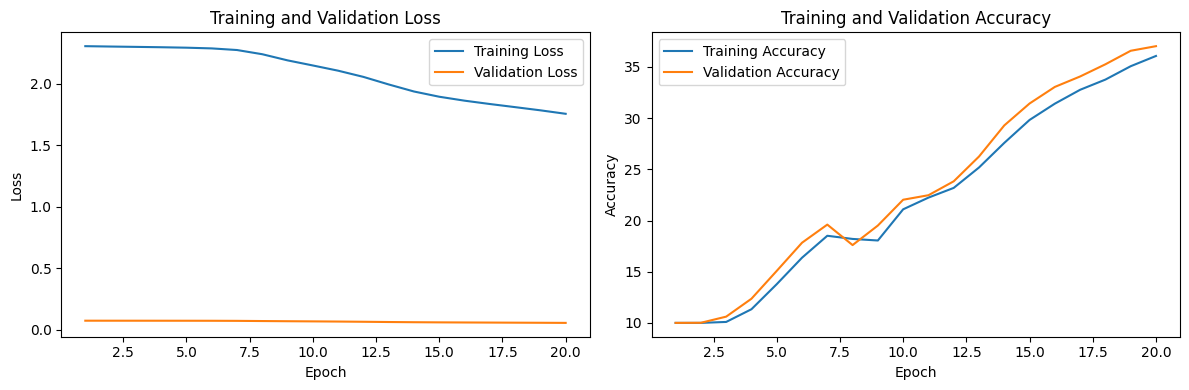

              precision    recall  f1-score   support

           0       0.46      0.49      0.48      1000
           1       0.44      0.57      0.50      1000
           2       0.25      0.21      0.23      1000
           3       0.21      0.04      0.07      1000
           4       0.32      0.16      0.21      1000
           5       0.34      0.38      0.36      1000
           6       0.31      0.62      0.41      1000
           7       0.32      0.30      0.31      1000
           8       0.47      0.54      0.50      1000
           9       0.45      0.39      0.42      1000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.35     10000
weighted avg       0.36      0.37      0.35     10000



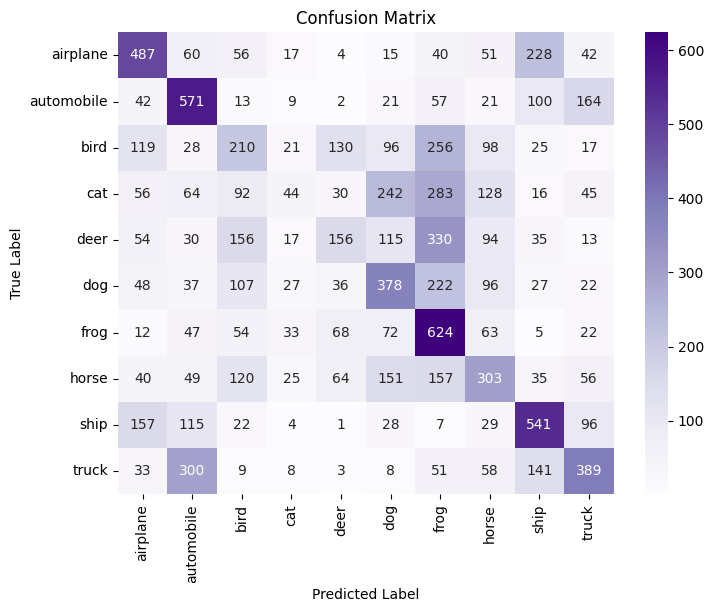

In [17]:
## Another way to calculate model parameters
# total_params = sum(p.numel() for p in net.parameters())
# print(f'Total number of parameters in the model: {total_params}')

summary(model, (3, 32, 32))  # Input images are of shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, epochs + 1)

# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()